In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')

from math import sin, cos, sqrt, atan2, radians
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from datetime import timedelta
import datetime as dt
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import pickle
import calendar
import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-46b61608589e>:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
train = pd.read_csv("/Users/kimjw/Desktop/Kaggle/week/train.csv")
test = pd.read_csv("/Users/kimjw/Desktop/Kaggle/week/test.csv")

In [3]:
train.dtypes

id                    object 
vendor_id             int64  
pickup_datetime       object 
dropoff_datetime      object 
passenger_count       int64  
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag    object 
trip_duration         int64  
dtype: object

In [4]:
# object에서 datetime형식으로 형변환
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime']=pd.to_datetime(train['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
train.dtypes

id                    object        
vendor_id             int64         
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count       int64         
pickup_longitude      float64       
pickup_latitude       float64       
dropoff_longitude     float64       
dropoff_latitude      float64       
store_and_fwd_flag    object        
trip_duration         int64         
dtype: object

In [5]:
# 데이터 이상여부 확인 위해 결측치 확인 => 결측치 없음
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
# 데이터 추출 시간 => 6달 가량의 데이터
print("Min pickup time: ", min(train["pickup_datetime"]))
print("Max pickup time: ", max(train["pickup_datetime"]))

Min pickup time:  2016-01-01 00:00:17
Max pickup time:  2016-06-30 23:59:39


In [7]:
# create date(날짜), day(일), hour(시간), week(요일) info from Pickup/Pickoff time
train["pickup_date"] = train["pickup_datetime"].dt.date
train["pickup_day"] = train["pickup_datetime"].apply(lambda x: x.day)
train["pickup_hour"] = train["pickup_datetime"].apply(lambda x: x.hour)
train["pickup_day_of_week"] = train["pickup_datetime"].apply(lambda x: calendar.day_name[x.weekday()])

train["dropoff_date"] = train["dropoff_datetime"].dt.date
train["dropoff_day"] = train["dropoff_datetime"].apply(lambda x: x.day)
train["dropoff_hour"] = train["dropoff_datetime"].apply(lambda x: x.hour)
train["dropoff_day_of_week"] = train["dropoff_datetime"].apply(lambda x: calendar.day_name[x.weekday()])

In [8]:
# 위,경도 소수점 3자리까지 나타나도록
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

In [9]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


In [10]:
# 이동거리 계산 함수
def calculateDistance(row):
    R = 6373.0
    pickup_lat = radians(row["pickup_latitude"])
    pickup_lon = radians(row["pickup_longitude"])
    dropoff_lat = radians(row["dropoff_latitude"])
    dropoff_lon = radians(row["dropoff_longitude"])
    diff_lon = dropoff_lon - pickup_lon
    diff_lat = dropoff_lat - pickup_lat
    a = sin(diff_lat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(diff_lon / 2) **2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [11]:
train["trip_distance"] = train.apply(lambda row: calculateDistance(row), axis =1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [12]:
train["trip_duration_in_hour"] = train["trip_duration"].apply(lambda x: x/3600)
train[["trip_duration","trip_duration_in_hour"]]

,trip_duration,trip_duration_in_hour
0,455,0.126389
1,663,0.184167
2,2124,0.590000
3,429,0.119167
4,435,0.120833
...,...,...
1458639,778,0.216111
1458640,655,0.181944
1458641,764,0.212222
1458642,373,0.103611


* trip_duration은 초당 이동시간
* trip_duration_in_hour은 시간당 이동시간

### Explanatory Analysis

#### trip_duration_in_hour

In [13]:
train["trip_duration_in_hour"].describe()

count    1.458644e+06
mean     2.665256e-01
std      1.454842e+00
min      2.777778e-04
25%      1.102778e-01
50%      1.838889e-01
75%      2.986111e-01
max      9.795228e+02
Name: trip_duration_in_hour, dtype: float64

In [14]:
# 24시간이 넘어가면 이상치일 확률 높다
outlier_trip_duration = train.loc[train["trip_duration_in_hour"]>24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


* 총 4개의 경우가 확인
* 이동시간은 길지만 이동거리는 상대적으로 짧음 => 이상치 변수들
* 하지만 이러한 데이터도 테스트 데이터의 일부일 수 있으므로 분석에서 제거하지 않음

Text(0.5, 0, 'Trip Duration (in hour)')

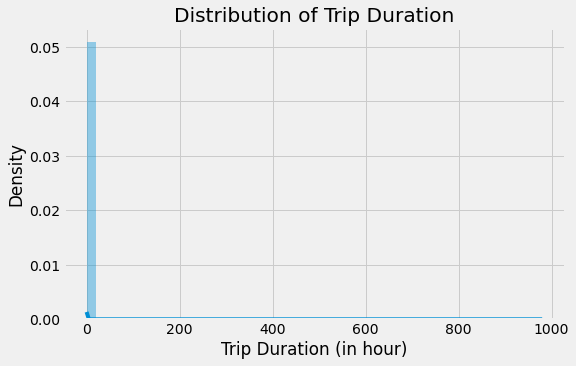

In [15]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

* skewed되어 있다 -> log transformation 필요

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

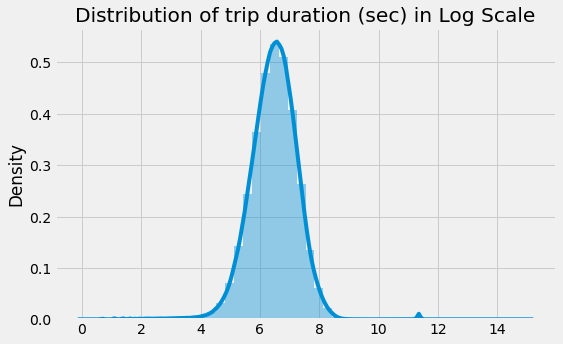

In [16]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values))
plt.title("Distribution of trip duration (sec) in Log Scale")

* 로그 변환을 해주었더니 정규분포에 근사
* exp(4)=54와 exp(8)=2980초 사이에 대부분 위치
* 대부분 이동시간이 한시간 이내
* 1분 미만이거나 100시간 이상인 경우도 존재 -> 좀 더 살펴볼 필요가 있다

**Heatmap of common locations from where pickup and dropoff occurs**

In [17]:
pickup = train.groupby(["pickup_latitude_round3", "pickup_longitude_round3"])["id"].count().reset_index().rename(columns={"id": "Num_Trips"})
pickup

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1
...,...,...,...
13019,43.140,-72.591,1
13020,43.487,-74.195,1
13021,43.912,-71.882,1
13022,44.372,-66.972,1


In [18]:
np.array(pickup.Num_Trips.values).astype('float64')

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

In [20]:
hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)),
                 min_opacity=0.2,
                 radius=5,
                 blur=15,
                 max_zoom=1)

In [21]:
pickup_map.add_child(hm_wide) # JSON오류...
pickup_map

TypeError: Object of type int64 is not JSON serializable

(-74.03, -73.75)

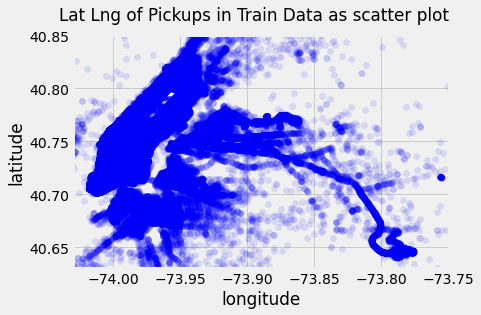

In [22]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train["pickup_longitude"], train["pickup_latitude"],
          color="b", alpha=0.1)
fig.suptitle("Lat Lng of Pickups in Train Data as scatter plot")

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

* JFK 공항에 밀도가 높다

In [23]:
drop = train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})
drop.dtypes

dropoff_latitude_round3     float64
dropoff_longitude_round3    float64
Num_Trips                   int64  
dtype: object

In [24]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)

* dropOff heatmap도 pickup때와 비슷하게 나올것

### 시간대
* 어느 시간대에 택시이용률이 높을까

Text(0.5, 1.0, 'Pickup Hours Distribution')

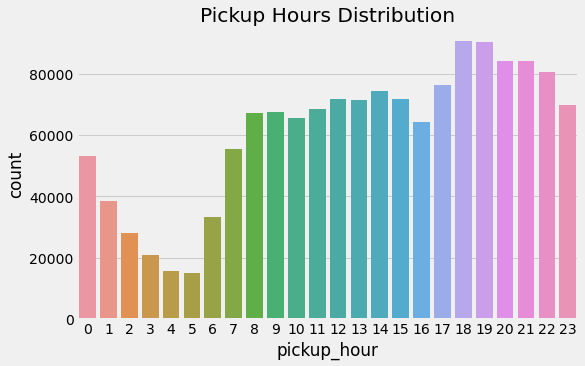

In [25]:
plt.figure(figsize=(8,5))
sns.countplot(x=train["pickup_hour"])
plt.title("Pickup Hours Distribution")

* 이른 오전에는 택시타는 사람이 많이 없다
* 오후 6~7시 사이에 가장 많이 탔다

Text(0.5, 1.0, 'Dropoff Hours Distribution')

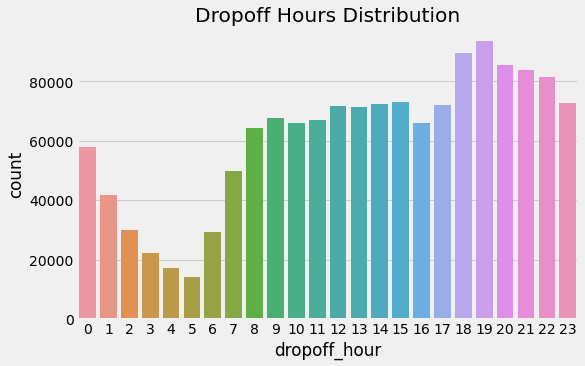

In [26]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

* pickup 분포와 유사하다

### 전체 pickup 시간대 분포

Text(0.5, 1.0, 'Distribution of Pickups over time')

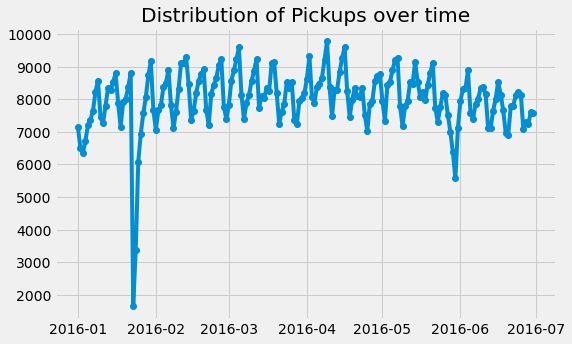

In [27]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-',label='train')


plt.title("Distribution of Pickups over time")

* 1월말에 급격한 하강한 패턴을 볼 수 있다

### 이동 거리

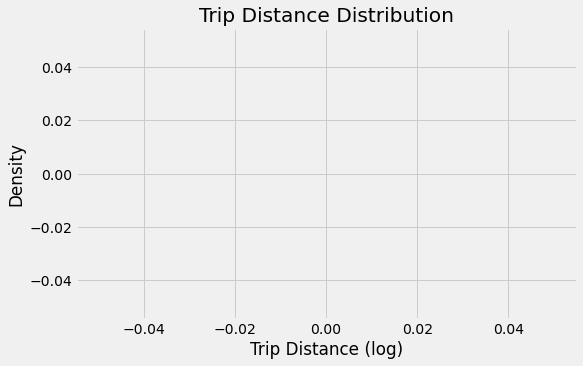

In [28]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")
plt.show()

### 이동시간 vs 이동거리

Text(0, 0.5, 'Trip Duration (log scale)')

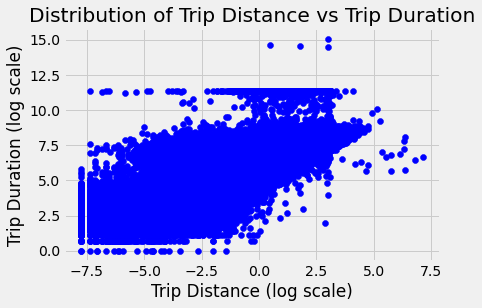

In [29]:
plt.scatter(np.log(train["trip_distance"].values),
           np.log(train["trip_duration"].values),
           color = "blue", label = "train")
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

### 시간대별 평균 trip_duration

In [30]:
avg_duration_hour = train.groupby(["pickup_hour"])["trip_duration"].mean().reset_index().rename(columns={"trip_duration": "avg_trip_duration"})
avg_duration_hour.head()

,pickup_hour,avg_trip_duration
0,0,936.657302
1,1,903.087112
2,2,890.076934
3,3,890.070878
4,4,921.976444


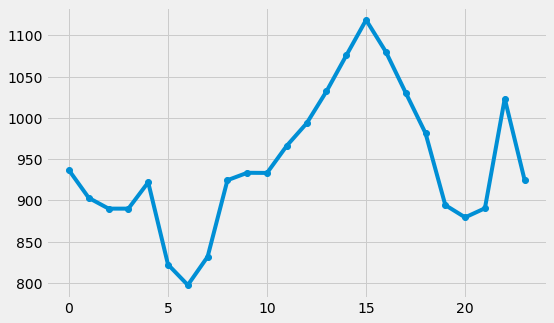

In [31]:
plt.figure(figsize=(8,5))
plt.plot(avg_duration_hour["avg_trip_duration"], "o-")

* 평균 trip_duration은 10시에서 3시사이에 증가하는 추세를 보인다

### 요일별 픽업 분포

<AxesSubplot:xlabel='pickup_day_of_week', ylabel='count'>

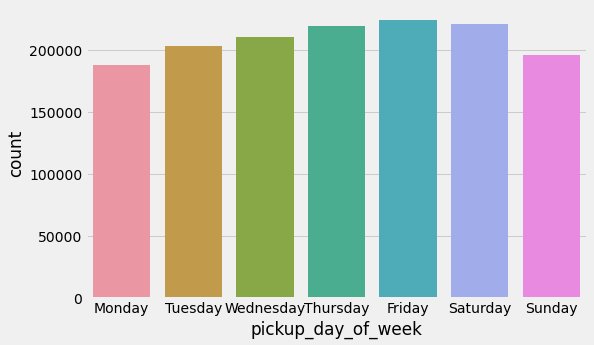

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(train["pickup_day_of_week"],
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])

* 월요일에 픽업수가 가장 적고, 화요일부터 금요일까지는 증가하는 추세를 보인다

### 요일별 평균 여행 지속시간

In [33]:
avg_duration_day = train.groupby(["pickup_day_of_week"])["trip_duration"].mean().reset_index().rename(columns={"trip_duration":"avg_trip_duration"})

Text(0.5, 1.0, 'AVG Trip Duration vs Pickup Days of Week')

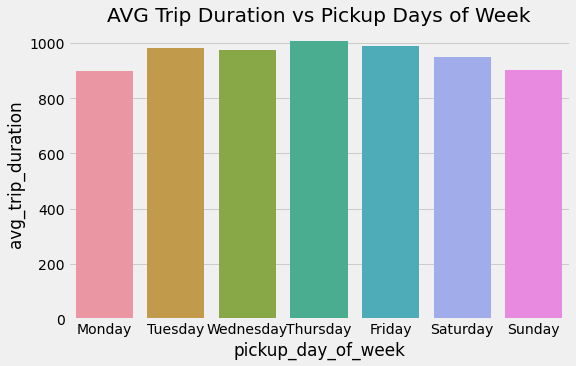

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(data = avg_duration_day,x="pickup_day_of_week", y="avg_trip_duration",
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
plt.title("AVG Trip Duration vs Pickup Days of Week")

* 목요일이 가장 높다

### 여행 방향 측정ㅡ 변수 만들기

In [35]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [36]:
train['bearing']=train.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),
                             axis=1)

<AxesSubplot:xlabel='bearing', ylabel='Density'>

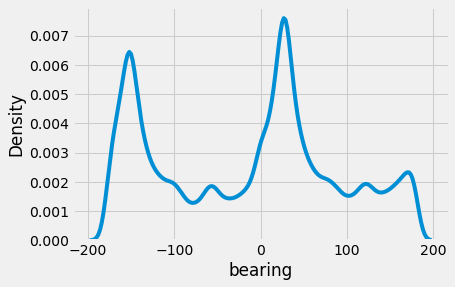

In [37]:
sns.kdeplot(train["bearing"])

### Bearing vs Trip Duration

Text(0, 0.5, 'Trip Duration (log scale)')

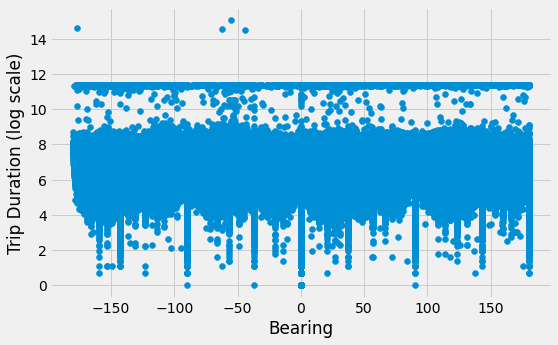

In [38]:
plt.figure(figsize=(8,5))
plt.scatter(train['bearing'].values,y=np.log(train['trip_duration'].values))
plt.xlabel("Bearing")
plt.ylabel("Trip Duration (log scale)")

* -50도 부근에서 3건의 이상치가 관측된다

### Store_and_FWD_Flag의 분포 - 녹화가 진행되었는지 여부

In [39]:
train["store_and_fwd_flag"].value_counts()

N    1450599
Y    8045   
Name: store_and_fwd_flag, dtype: int64

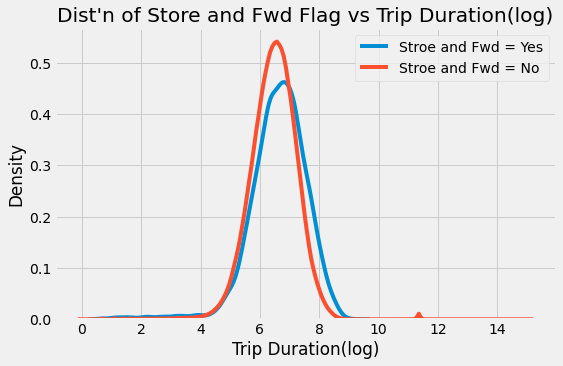

In [40]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train.loc[train["store_and_fwd_flag"]=="Y","trip_duration"].values),
           label="Stroe and Fwd = Yes")
sns.kdeplot(np.log(train.loc[train["store_and_fwd_flag"]=="N","trip_duration"].values),
           label="Stroe and Fwd = No")

plt.title("Dist'n of Store and Fwd Flag vs Trip Duration(log)")
plt.xlabel("Trip Duration(log)")
plt.ylabel("Density")
plt.legend()

* 5~7시간 여행에서는 store_and_fwd_flag값이 No인 경우가 더 많이 분포하고 있다

### Group Locations into cluster
* 이 과정은 지역을 생성하는 데 도움이 될 것 같다
* 특정 지역에서의 픽업은 더 긴 여행시간을 가질 수 있다

In [41]:
# train과 test데이터 모두 통합해서 위/경도 자료 취합
coords = np.vstack((train[["pickup_latitude","pickup_longitude"]].values,
                   train[["dropoff_latitude","dropoff_longitude"]].values,
                   test[["pickup_latitude","pickup_longitude"]].values,
                   test[["dropoff_latitude","dropoff_longitude"]].values))

In [42]:
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [43]:
# 취합한 위/경도 자료를 바탕으로 8개의 클러스터 생성
kmeans = KMeans(n_clusters=8, random_state=0).fit(coords)

In [44]:
train.loc[:, 'pickup_neighbourhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

In [45]:
train[['pickup_neighbourhood','dropoff_neighbourhood']]

,pickup_neighbourhood,dropoff_neighbourhood
0,0,6
1,0,3
2,0,3
3,3,3
4,6,6
...,...,...
1458639,0,3
1458640,0,6
1458641,6,3
1458642,0,0


In [46]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

(-74.03, -73.75)

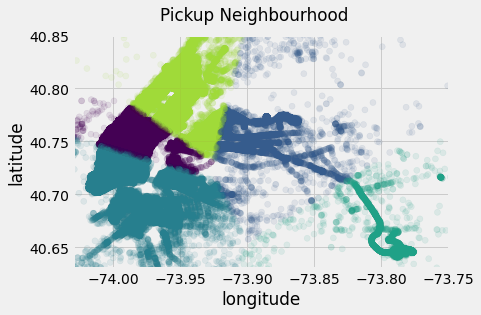

In [47]:
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train["pickup_longitude"], train["pickup_latitude"],
          c=train["pickup_neighbourhood"],
          alpha=0.1)
fig.suptitle("Pickup Neighbourhood")
ax.set_ylabel("latitude")
ax.set_xlabel("longitude")
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

### 각 지역(8개) 내에서 pickup 수 -> 여행빈도?

Text(0.5, 1.0, 'Distribution of Number of Pickups across Neighbourhoods')

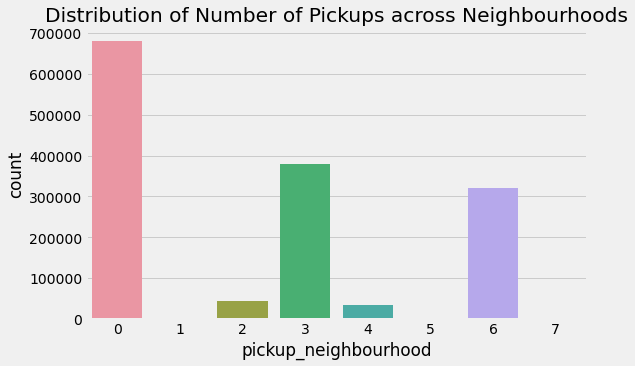

In [48]:
plt.figure(figsize=(8,5))
sns.countplot(train["pickup_neighbourhood"])
plt.title("Distribution of Number of Pickups across Neighbourhoods")

* 0,3,6 지역에서 pickup의 수가 많다

### 각 지역 간 평균 여행 시간

In [49]:
avg_duration_neighbourhood=train.groupby(["pickup_neighbourhood"])["trip_duration"].mean().reset_index().rename(columns={"trip_duration":"avg_trip_duration"})
avg_duration_neighbourhood

,pickup_neighbourhood,avg_trip_duration
0,0,886.878576
1,1,802.000000
2,2,1811.339046
3,3,963.014122
4,4,2711.060748
5,5,495.333333
6,6,809.677980
7,7,446.181818


Text(0.5, 1.0, 'Avg Trip Duration vs Neighbourhood')

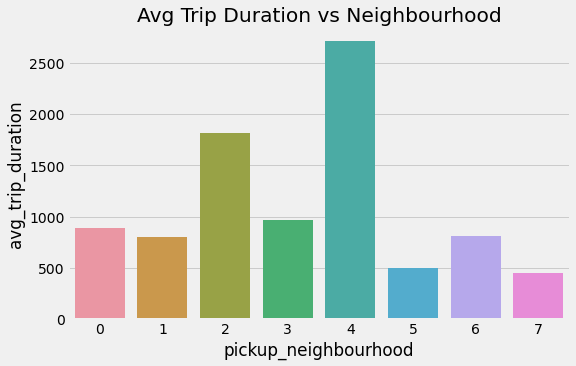

In [50]:
plt.figure(figsize=(8,5))
sns.barplot(data=avg_duration_neighbourhood,
            x="pickup_neighbourhood", y="avg_trip_duration")
plt.title("Avg Trip Duration vs Neighbourhood")

* 상대적으로 4,2 지역에서 평균 여행시간이 길다
* 위의 그래프와 비교했을 때 4,2 지역은 여행빈도가 높은 편은 아니지만 일단 여행하면 여행시간이 길어진다 

### 평균 속도 분포

In [51]:
train['avg_speed_kph']=train['trip_distance']/train['trip_duration_in_hour']

(0.0, 2000.0)

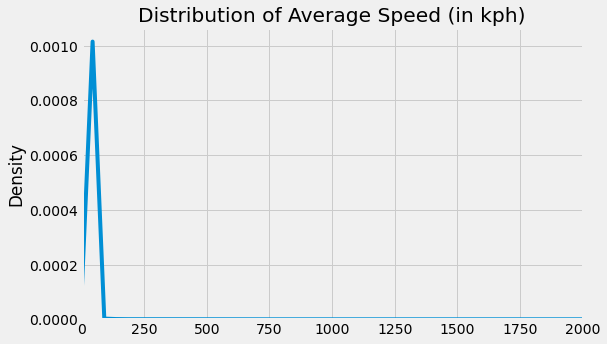

In [52]:
plt.figure(figsize=(8,5))
sns.kdeplot(train["avg_speed_kph"].values)
plt.title("Distribution of Average Speed (in kph)")
plt.xlim(0,2000)

In [53]:
train["avg_speed_kph"].describe()

count    1.458644e+06
mean     1.442774e+01
std      1.498223e+01
min      0.000000e+00
25%      9.124138e+00
50%      1.279599e+01
75%      1.785051e+01
max      9.277748e+03
Name: avg_speed_kph, dtype: float64

In [54]:
print("Average speed is","%.2f" %np.mean(train['avg_speed_kph']),"kph")

Average speed is 14.43 kph


### 요일별 평균 교통 속도 

In [55]:
avg_speed_per_day=train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()

Text(0.5, 1.0, 'Avg Speed (kph) vs Pickup Days of Week')

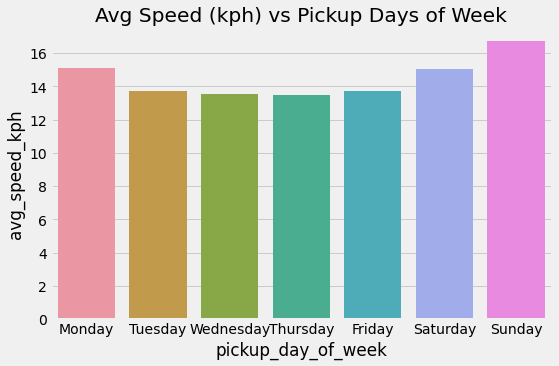

In [56]:
plt.figure(figsize=(8,5))
sns.barplot(data=avg_speed_per_day,
           x="pickup_day_of_week",y="avg_speed_kph",
           order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
plt.title("Avg Speed (kph) vs Pickup Days of Week")

일요일과 월요일에 평균 속도가 높다

## Feature Engineering on Test Data

In [108]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
#test['dropoff_datetime']=pd.to_datetime(test['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
#test['dropoff_date']= test['dropoff_datetime'].dt.date
#test['dropoff_day']=test['dropoff_datetime'].apply(lambda x:x.day)
#test['dropoff_hour']=test['dropoff_datetime'].apply(lambda x:x.hour)
#test['dropoff_day_of_week']=test['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:calculateDistance(row),axis=1)
#test['trip_duration_in_hour']=test['trip_duration'].apply(lambda x:x/3600)
test['bearing']=test.apply(lambda row:calculateBearing(row['pickup_latitude_round3'],row['pickup_longitude_round3'],row['dropoff_latitude_round3'],row['dropoff_longitude_round3']),axis=1)
test.loc[:, 'pickup_neighbourhood'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

## Building Models
* From the training data we need to drop "dropoff datetime features". 
* We also only keep lat lng rounded to 3 decimal places

In [109]:
drop_cols=['avg_speed_kph','trip_duration_in_hour','dropoff_date','dropoff_day','dropoff_hour','dropoff_day_of_week','dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
training=train.drop(drop_cols,axis=1)
training.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_day',
       'pickup_hour', 'pickup_day_of_week', 'pickup_latitude_round3',
       'pickup_longitude_round3', 'dropoff_latitude_round3',
       'dropoff_longitude_round3', 'trip_distance', 'bearing',
       'pickup_neighbourhood', 'dropoff_neighbourhood'],
      dtype='object')

In [110]:
testing=test.drop(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)
testing.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'store_and_fwd_flag', 'pickup_date', 'pickup_day', 'pickup_hour',
       'pickup_day_of_week', 'pickup_latitude_round3',
       'pickup_longitude_round3', 'dropoff_latitude_round3',
       'dropoff_longitude_round3', 'trip_distance', 'bearing',
       'pickup_neighbourhood', 'dropoff_neighbourhood'],
      dtype='object')

* 우리가 예측해야하는 변수는 trip_duration
* 위에서 trip_duration은 skewed되어있었기 때문에 로그변환

In [111]:
training["log_trip_duration"] = training["trip_duration"].apply(lambda x:np.log(x))
training.drop(["trip_duration"],axis=1,inplace=True)

In [112]:
training.shape

(1458644, 18)

In [113]:
testing.shape

(625134, 17)

In [114]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   id                        1458644 non-null  object        
 1   vendor_id                 1458644 non-null  int64         
 2   pickup_datetime           1458644 non-null  datetime64[ns]
 3   passenger_count           1458644 non-null  int64         
 4   store_and_fwd_flag        1458644 non-null  object        
 5   pickup_date               1458644 non-null  object        
 6   pickup_day                1458644 non-null  int64         
 7   pickup_hour               1458644 non-null  int64         
 8   pickup_day_of_week        1458644 non-null  object        
 9   pickup_latitude_round3    1458644 non-null  float64       
 10  pickup_longitude_round3   1458644 non-null  float64       
 11  dropoff_latitude_round3   1458644 non-null  float6

In [115]:
# object형 변수를 모델에서 식별할 수 있도록 인코딩
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict

In [116]:
training["pickup_day_of_week"] = training["pickup_day_of_week"].apply(lambda x: encodeDays(x))
testing["pickup_day_of_week"] = testing["pickup_day_of_week"].apply(lambda x: encodeDays(x))

In [121]:
training.to_csv("input_training.csv",index=False)
testing.to_csv("input_testing.csv",index=False)
del training
del testing
del train
del test

In [122]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]

In [123]:
def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)
    
    training,testing=LabelEncoding(training,testing)
    
    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [124]:
train,test=readInputAndEncode("",'input_training.csv','input_testing.csv','log_trip_duration')

Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [125]:
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)

test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

In [127]:
def GetFeaturesAndSplit(train,test,target,imputing_strategy='median',split=0.25,imputation=True):
    labels=np.array(train[target])
    training=train.drop(target, axis = 1)
    training = np.array(training)
    testing=np.array(test)
    if imputation==True:
        imputer=Imputer(strategy=imputing_strategy,missing_values=np.nan)
        imputer.fit(training)
        training=imputer.transform(training)
        testing=imputer.transform(testing)
    train_features, validation_features, train_labels, validation_labels = train_test_split(training, labels, test_size = split, random_state = 42)
    return [train_features,validation_features,train_labels,validation_labels,testing]

In [128]:
train_features,validation_features,train_labels,validation_labels,testing=GetFeaturesAndSplit(train,test,'log_trip_duration',imputation=False)

## Linear Regression

In [129]:
lm=linear_model.LinearRegression()
lm.fit(train_features,train_labels)

LinearRegression()

In [130]:
valid_pred=lm.predict(validation_features)

In [131]:
rmse=mean_squared_error(validation_labels,valid_pred)
print("Root Mean Squared Error for Linear Regression(log scale) ",rmse)

Root Mean Squared Error for Linear Regression(log scale)  0.40123121968828623


In [141]:
test_pred=lm.predict(testing)
submit=pd.DataFrame()
submit['id']=test_id
# exp를 하는 이유는 trip_duration에 로그변환을 취했었기 때문
submit['trip_duration']=np.exp(test_pred)

In [143]:
submit

,id,trip_duration
0,id3004672,668.435260
1,id3505355,630.568719
2,id1217141,523.676914
3,id2150126,791.221703
4,id1598245,544.003054
...,...,...
625129,id3008929,438.914424
625130,id3700764,739.072392
625131,id2568735,1076.516205
625132,id1384355,4003.276401


## Random Forest Regressor

In [144]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [146]:
rf.fit(train_features,train_labels)

RandomForestRegressor(random_state=42)

In [147]:
valid_pred_rf = rf.predict(validation_features)
rmse=mean_squared_error(validation_labels, valid_pred_rf)
print("Root Mean Squared Error for Random Forest",rmse)

Root Mean Squared Error for Random Forest 0.17984696297398264


In [150]:
test_pred=rf.predict(testing)
submit2=pd.DataFrame()
submit2["id"]=test_id
submit2["trip_duration"]=np.exp(test_pred)

In [151]:
submit2

,id,trip_duration
0,id3004672,812.111655
1,id3505355,572.280551
2,id1217141,485.435083
3,id2150126,992.480791
4,id1598245,376.343900
...,...,...
625129,id3008929,270.308834
625130,id3700764,1733.926752
625131,id2568735,1413.317942
625132,id1384355,2037.053680
